In [20]:
# import needed libraries
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [21]:
# import data
data = pd.read_csv('./data/preprocessed/bigframeMirai2.csv')
# split data to data and bacground truth 

cols = data.columns.to_list()[1:18]
X = data[cols].to_numpy()
Y = data['label'].to_numpy()
print(data.shape)
print(X.shape)

(8747, 20)
(8747, 17)


In [22]:
# MLM-mallin "koulutus"
def mlm_fit(X, Y, R, T):
  D_x = sp.spatial.distance.cdist(X, R)
  Dlt_y = sp.spatial.distance.cdist(Y, T)
  B = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(D_x),D_x)),np.transpose(D_x)),Dlt_y)
  return B

In [23]:
# MLM testaus
def MLM_test(X_1, R, T, B):
  from scipy.optimize import least_squares

  def J_fun(y, delta_yT, T):
    return np.sum((np.multiply(np.transpose(y-T),(y-T))-delta_yT**2)**2)

  y = np.zeros(X_1.shape[0])
  a = np.zeros(X_1.shape[0])

  for i in range(X_1.shape[0]):
    d_xR = sp.spatial.distance.cdist(X_1[i,:].reshape(1,X_1.shape[1]),R)
    delta_yT = np.matmul(d_xR,B)
    y_hat = least_squares(J_fun,0,method='lm', args=(delta_yT,T))

    y[i] = y_hat.x[:]
    a[i] = np.sqrt(np.sum(delta_yT**2))
  
  return y, a

In [24]:
def MLM_maj_vote(X_test, R, T, B, k, metriX):
  y = np.zeros(X_test.shape[0])
  a = np.zeros(X_test.shape[0])

  d_xR = sp.spatial.distance.cdist(X_test, R, metric=metriX)
  delta_yT = np.matmul(d_xR, B)

  from scipy.stats import mode
  k_shortest_id = np.argsort(delta_yT)[:,k]
  y = mode(T[k_shortest_id,:],axis=1,keepdims=True)[0][:,0]

  return y

In [25]:
# Datan standardointi ja normalisointi
def normalize(X):
  minimum = X.min(axis=0, keepdims=True)
  maximum = X.max(axis=0, keepdims=True)
  keskihajonta = X.std(axis=0, keepdims=True)

  #print(minimum)
  #print(maximum)

  range = maximum - minimum
  #print(range)

  #forced range

  X_fRange = (X - minimum) / range
  X_ustd = X / keskihajonta

  #print(X_fRange.shape)
  return X_fRange


In [26]:
# Pääkomponenttianalyysi

def Pca(X):
  print(X.shape[1])
  pca = PCA(n_components=X.shape[1])
  X_pca = pca.fit_transform(X)
  #print(pca.singular_values_)
  return X_pca

In [27]:
# Datan jako opetus ja testidataan
def Split(X, Y):
  X_train, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42, shuffle=True)
  Y_train = Y_tr.reshape(X_train.shape[0],1)

  return (X_train, Y_train, X_test, Y_test)

In [28]:
# mallin tunnuslukujen laskeminen
def perfomanceKPIs(Y_result, Y_true):
  Y_res = np.floor(Y_result)
  from sklearn.metrics import confusion_matrix, classification_report
  #auc = confusion_matrix(Y_res, Y_true,)
  #names = ['Benign', 'C&C', 'C&C-FileDownload', 'DDoS', 'wrong']
  report = classification_report(Y_res, Y_true, zero_division=True)
  return report


In [41]:
X_norm = normalize(X)
#print(X_norm.shape)
X_pca = Pca(X_norm)
X_train, Y_train, X_test, Y_test = Split(X_pca, Y)

u = 103
R = X_train[::u,:]
T = Y_train[::u].reshape(Y_train[::u].shape[0],1)

B = mlm_fit(X_train, Y_train, R, T)

Y_fitted, a = MLM_test(X_test, R, T, B)
Y_voted = MLM_maj_vote(X_test, R, T, B, k=1, metriX='euclidean')

17


In [42]:
report_voted = perfomanceKPIs(Y_voted, Y_test)
report_fitted = perfomanceKPIs(Y_fitted, Y_test)
print('Luokitteluraportti, Majority voting')
print(report_voted)
print('Luokitteluraportti, etäisyyden minimointi')
print(report_fitted)

Luokitteluraportti, Majority voting
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       928
         1.0       0.00      0.00      0.00       227
         2.0       0.00      1.00      0.00         0
         3.0       0.00      1.00      0.00         0
         4.0       0.00      1.00      0.00         0
         5.0       0.11      0.05      0.07      2344

    accuracy                           0.04      3499
   macro avg       0.02      0.51      0.01      3499
weighted avg       0.07      0.04      0.05      3499

Luokitteluraportti, etäisyyden minimointi
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.62      3499
         1.0       0.00      1.00      0.00         0
         2.0       0.00      1.00      0.00         0
         3.0       0.00      1.00      0.00         0
         4.0       0.00      1.00      0.00         0
         5.0       0.00      1.00      0.00         0


Pisteet luokissa (esimerkkiajo):
|luokka|pisteitä <br>alkup.data|T|Y_train|Y_test|
|-|-|-|-|-|
|0| 3876|26|2322|1554|
|1| 1936|9|1138|798|
|2| 12|0|5|7|
|3| 1|0|0|1|
|4| 14|0|7|7|
|5| 2908|12|1776|1132|

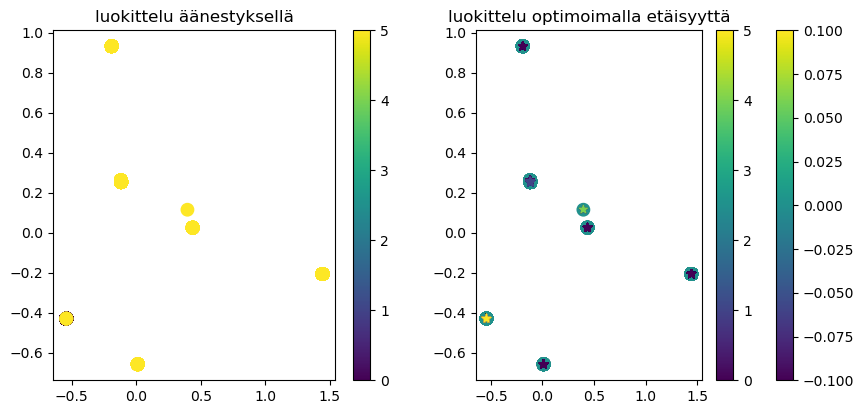

In [53]:
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.scatter(X_test[:,0],X_test[:,1],marker='o',c=Y_voted,sizes=[80])
plt.colorbar()
plt.scatter(X_train[:,0],X_train[:,1],marker='*',c=Y_train)
plt.colorbar()
plt.title('luokittelu äänestyksellä')

plt.subplot(222)
plt.scatter(X_test[:,0],X_test[:,1],marker='o',c=Y_fitted,sizes=[80])
plt.colorbar()
plt.scatter(X_train[:,0],X_train[:,1],marker='*',c=Y_train)
plt.colorbar()
plt.title('luokittelu optimoimalla etäisyyttä')

plt.savefig('image.png')